In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


<h1> Step 1: Define the libraries to be used </h1>

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline


<h1> Step 2: Load the DataSet </h1>

In [6]:
print(color.BOLD+color.PURPLE+'Preview of the sample data :')
#Reading train and test data 

df1=pd.read_excel('framingham.xlsx')
df1.head()

Preview of the sample data :


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


<h1> Step 3: Exploratory Data Analysis : checking size, shape of data sets, checking nulls and duplicates in a dataset </h1>

In [7]:
print(color.BOLD+color.PURPLE+'Dataset has',df1.shape[0],'rows and',df1.shape[1],'columns.')

Dataset has 4238 rows and 16 columns.


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [9]:
cat=[]
num=[]
for column in df1.columns:
    if df1[column].dtype == 'object':
        cat.append(column)
    else:
        num.append(column)

print(color.BOLD+color.PURPLE+'Categorical features in DataSet',cat)
print("\n")
print(color.BOLD+color.PURPLE+'Numberical features in DataSet',num)

Categorical features in DataSet []


Numberical features in DataSet ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']


In [10]:
def null_table(data):
    indices = data.isnull().sum().index
    values = data.isnull().sum().values
    percentages = []
    for i in indices:
        percentages.append((data[i].isnull().sum() / data[i].shape[0]) * 100)
    d = {'Columns' : indices, 'Count of Null Values' : values, 'Approximate Percentage of Null Values' : percentages}
    # data = dict(zip(indices, percentages))
    null_frame = pd.DataFrame(data = d)
    return null_frame


In [11]:
print(color.BOLD+color.PURPLE+"Missing values in dataset :\n")


Missing values in dataset :



In [12]:
null_frame_train = null_table(df1)
null_frame_train=null_frame_train[null_frame_train['Approximate Percentage of Null Values'] >0]
null_frame_train.sort_values(by='Approximate Percentage of Null Values',ascending=False)


,Columns,Count of Null Values,Approximate Percentage of Null Values
14,glucose,388,9.155262
2,education,105,2.477584
5,BPMeds,53,1.250590
9,totChol,50,1.179802
4,cigsPerDay,29,0.684285
12,BMI,19,0.448325
13,heartRate,1,0.023596


<h1> Data Set has null values, so we are filling the null values with mean  </h1>

In [13]:
df1.fillna(df1.mean(),inplace=True)

In [14]:
print(color.BOLD+color.PURPLE+"Duplicate check on dataset :\n")
duplicateRowsDF = df1[df1.duplicated()]
duplicateRowsDF.sum().sum()

Duplicate check on dataset :



0.0

<h1> Step 5: Data Visualization : Using Distribution Plot,Violin PLot, Box PLot(Outlier check), Correlation plot (Multicolinearity check)and Pair plot </h1>

C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\categorical.py:376: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-.5, len(self.plot_data) - .5, auto=None)
C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a f

C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\categorical.py:376: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-.5, len(self.plot_data) - .5, auto=None)
C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a f

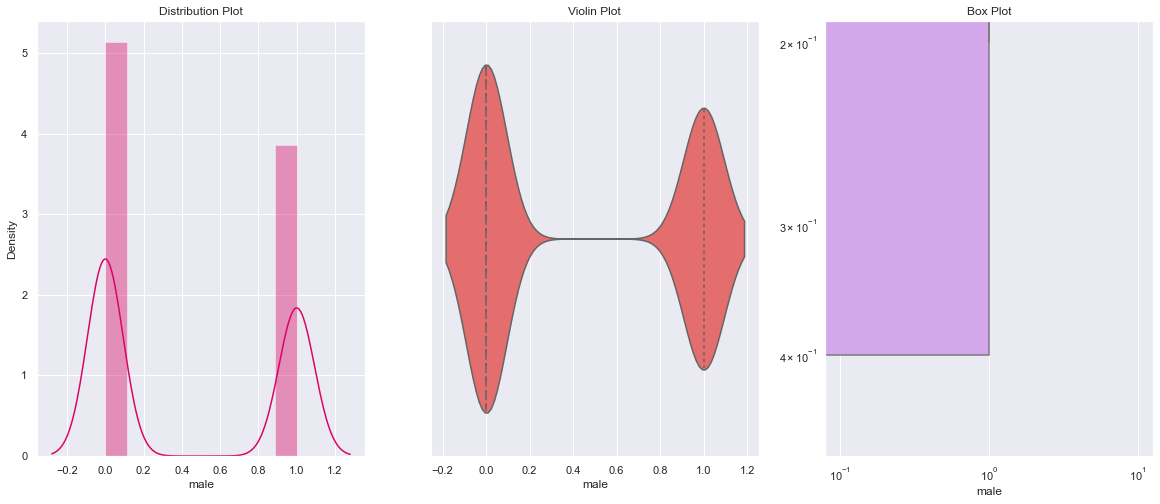

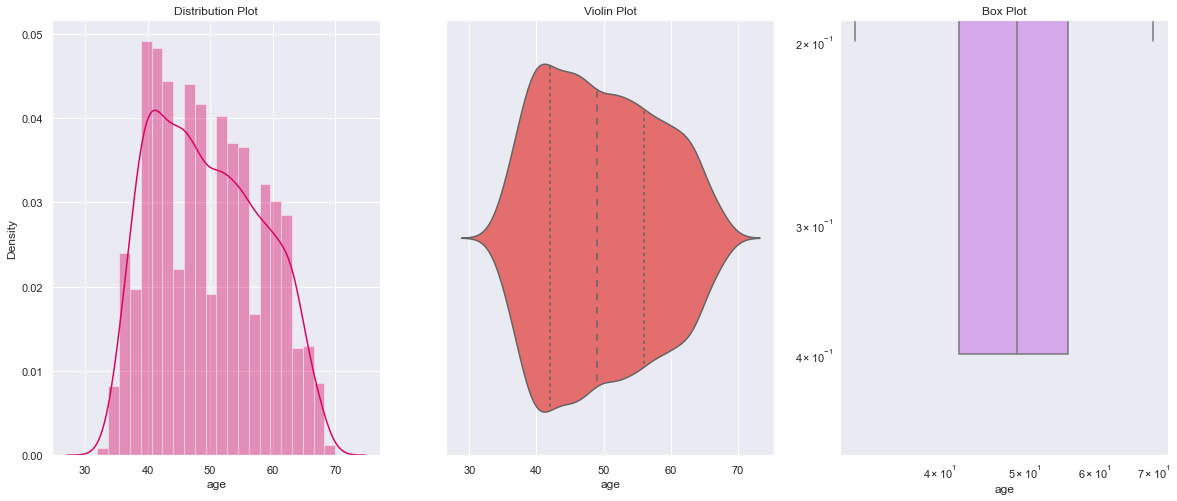

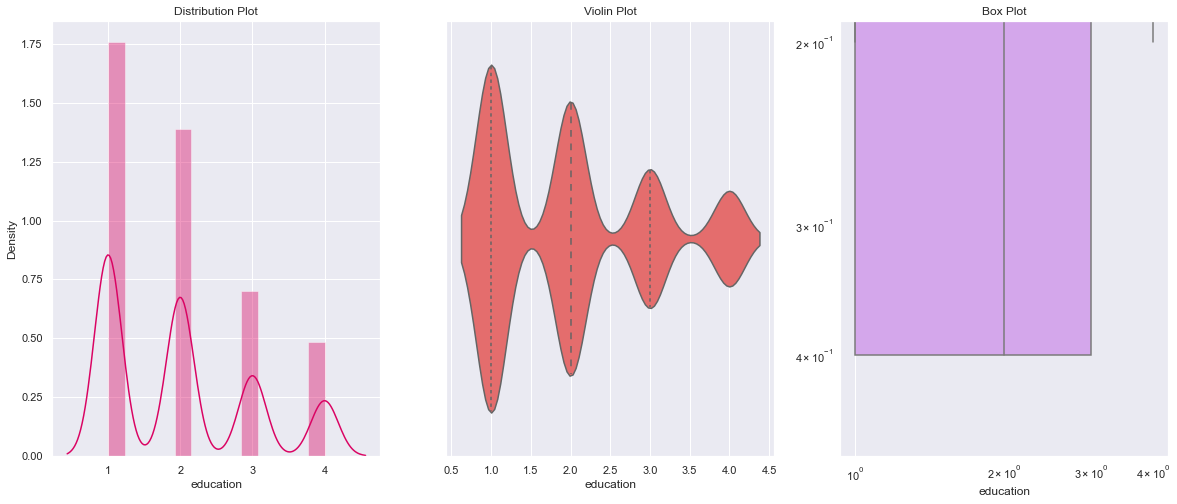

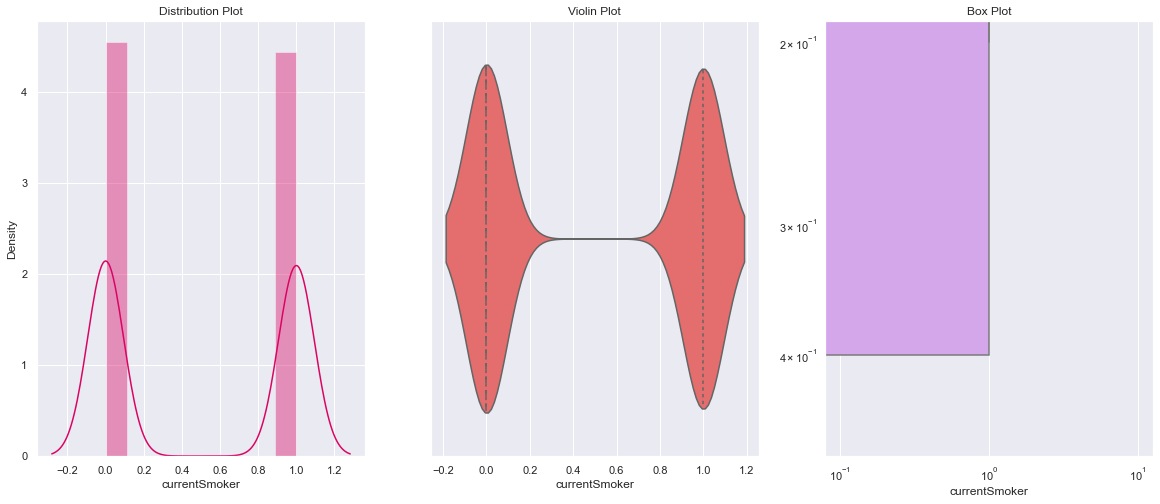

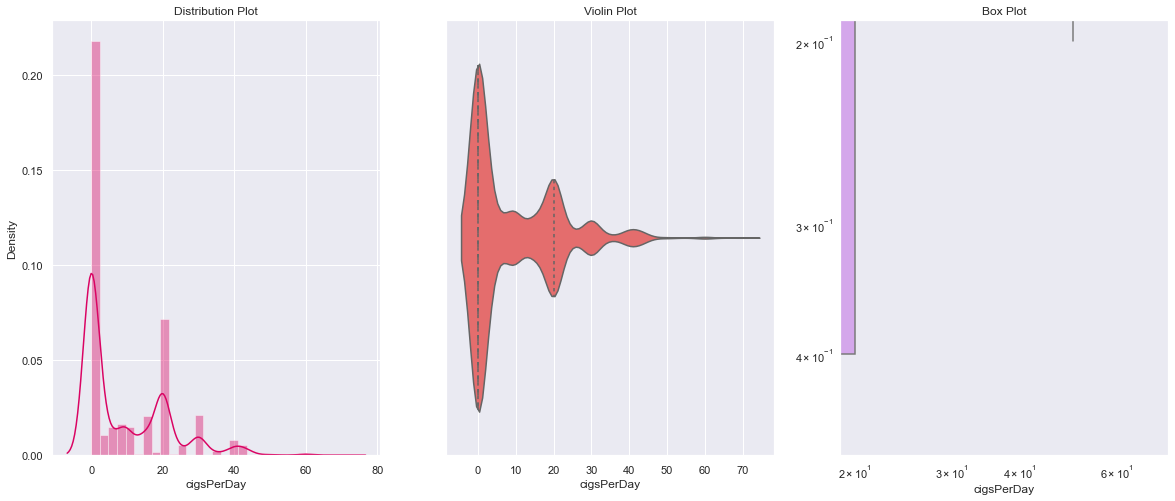

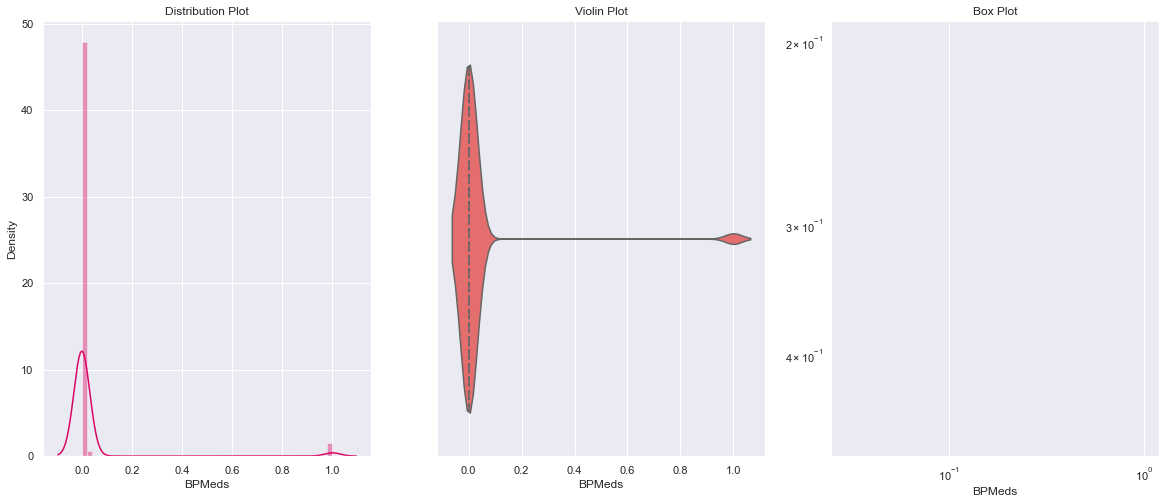

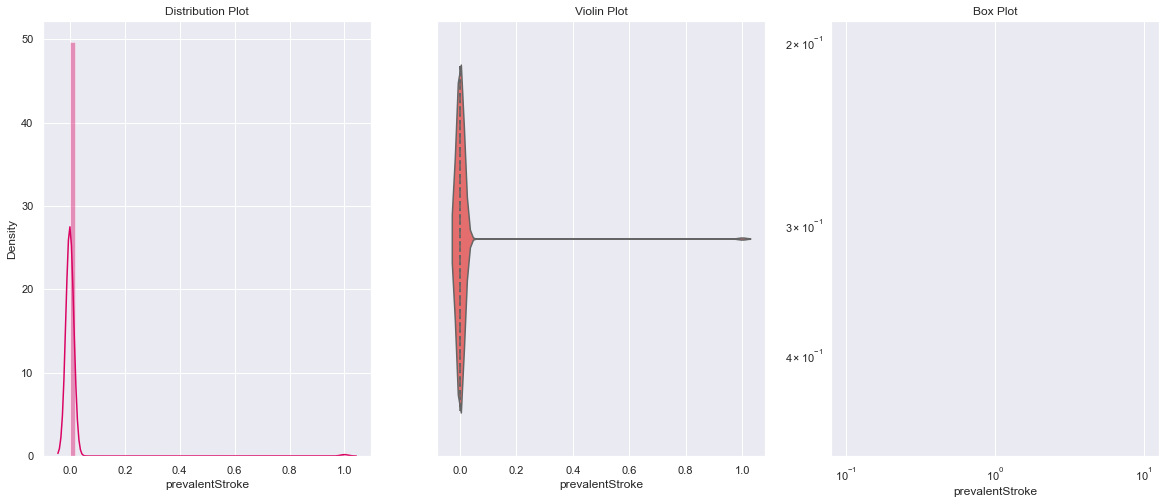

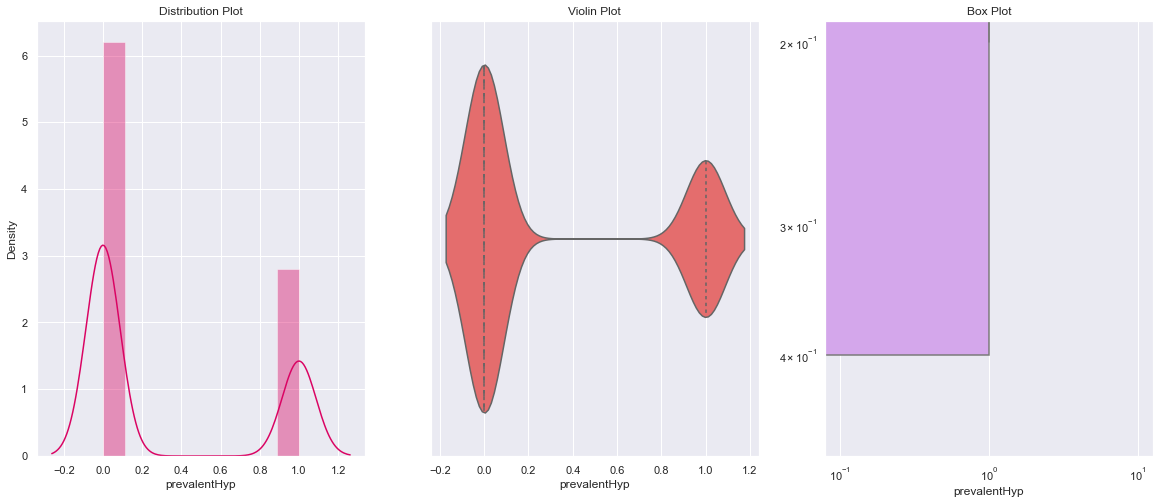

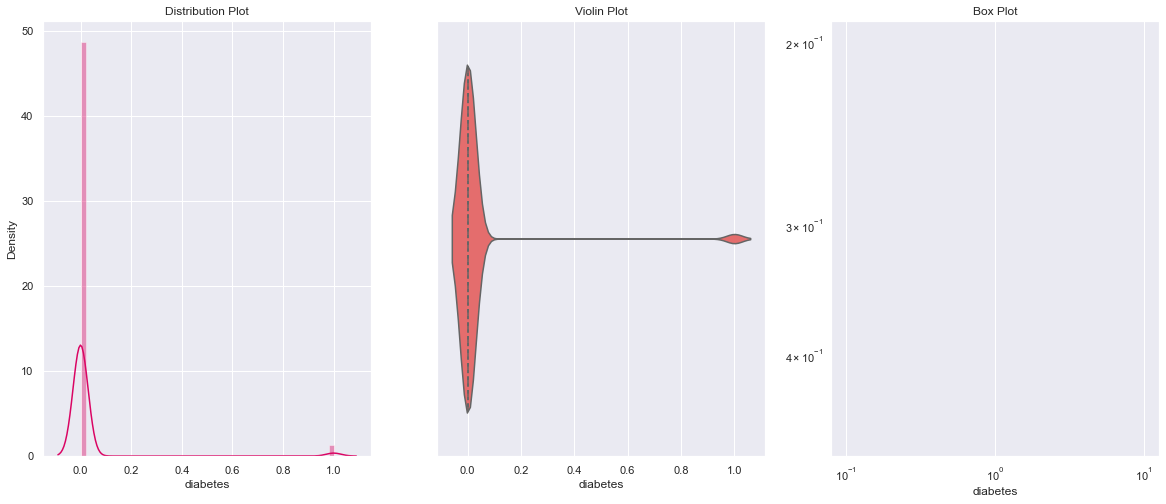

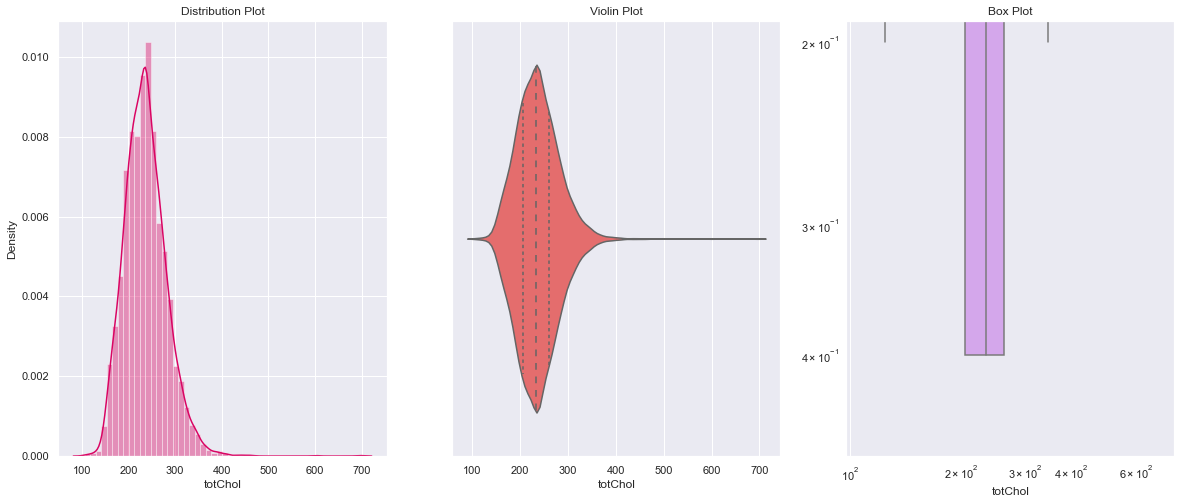

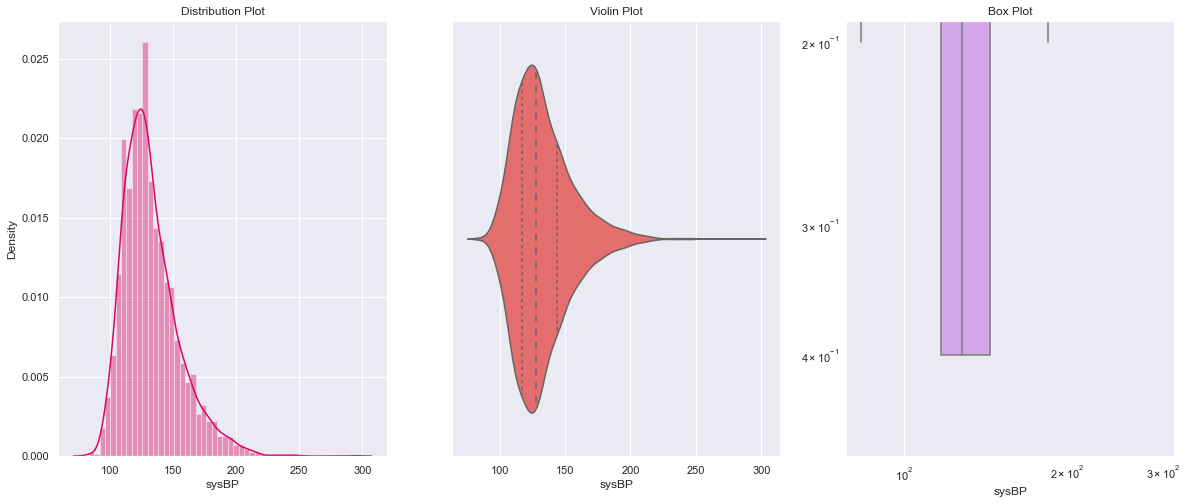

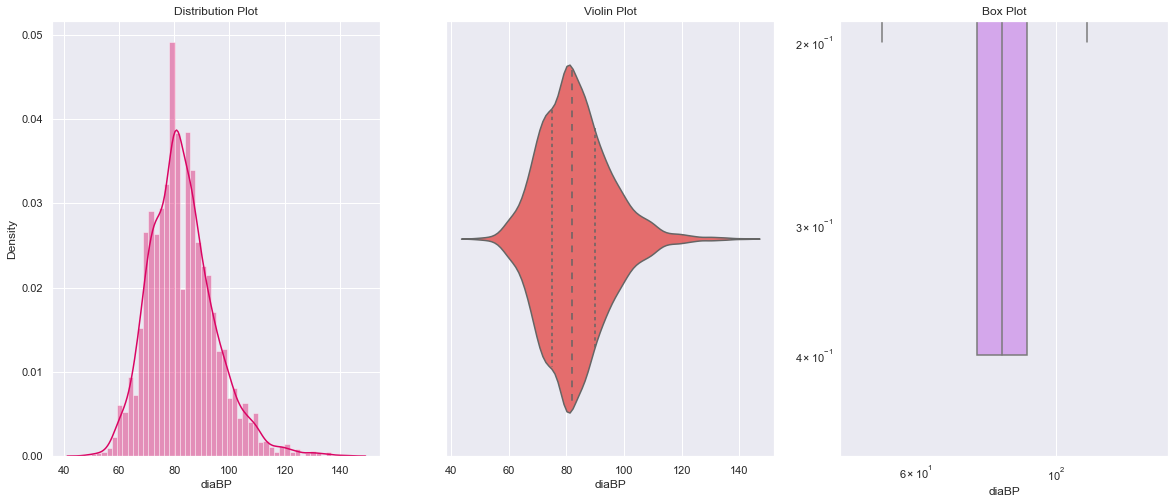

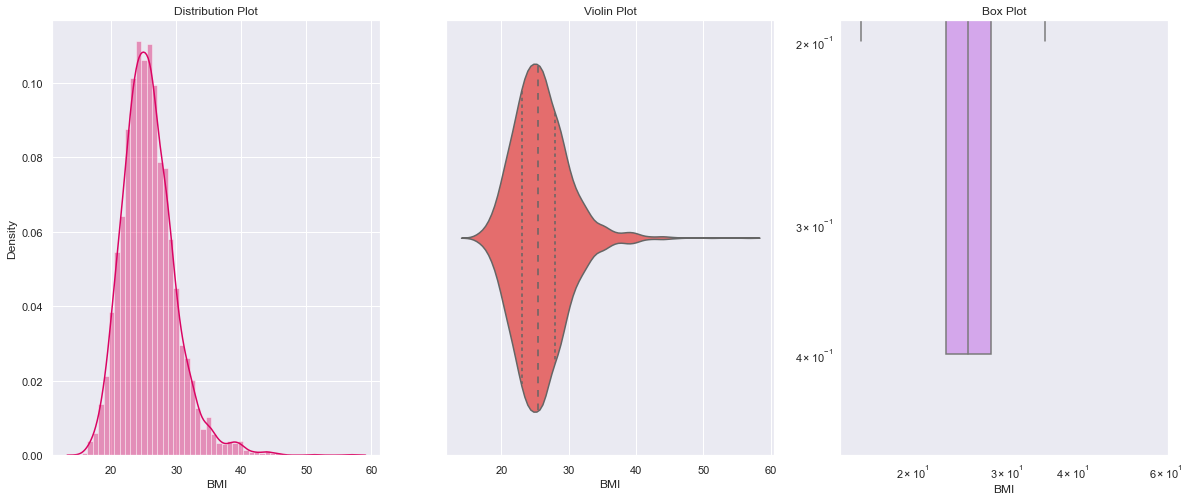

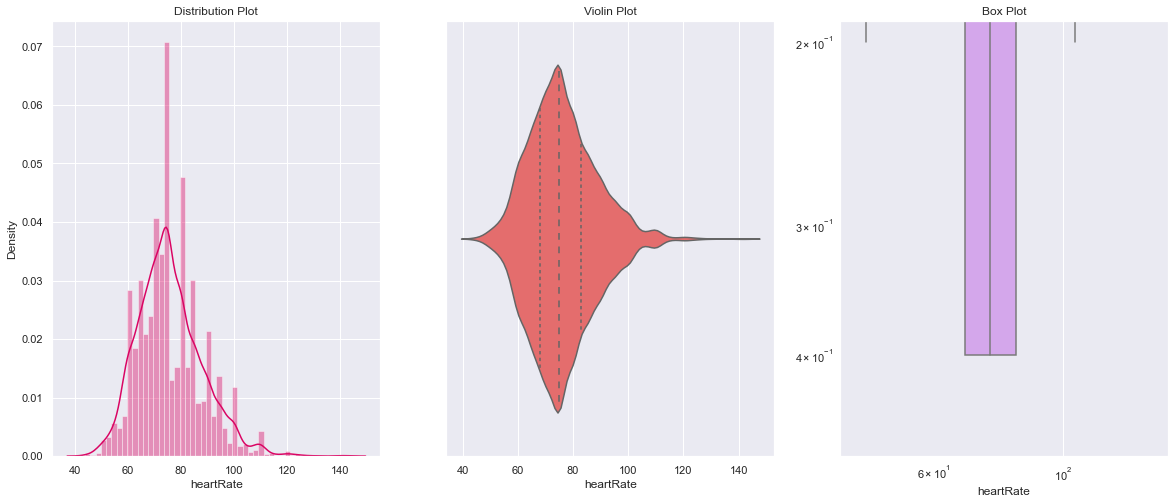

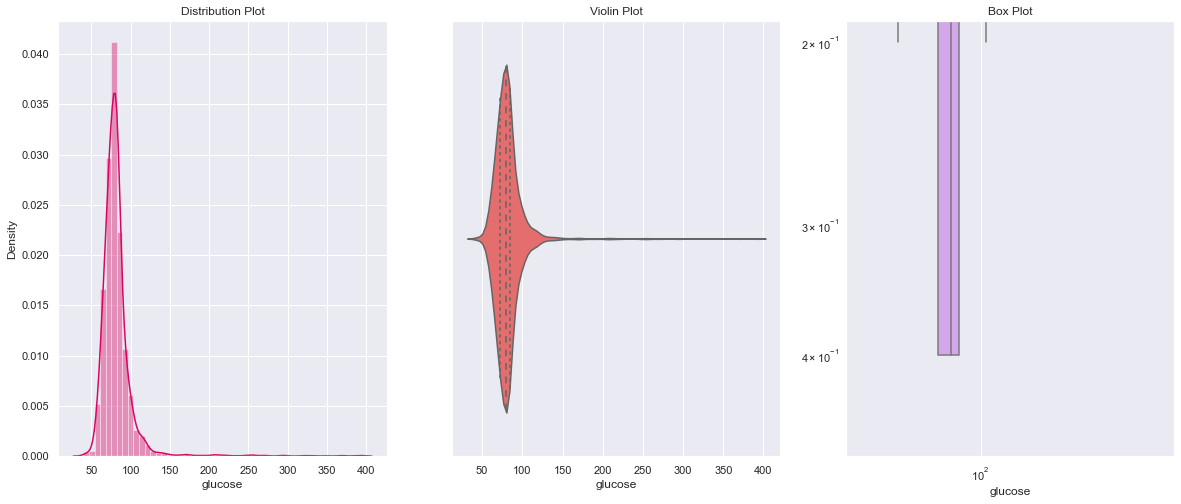

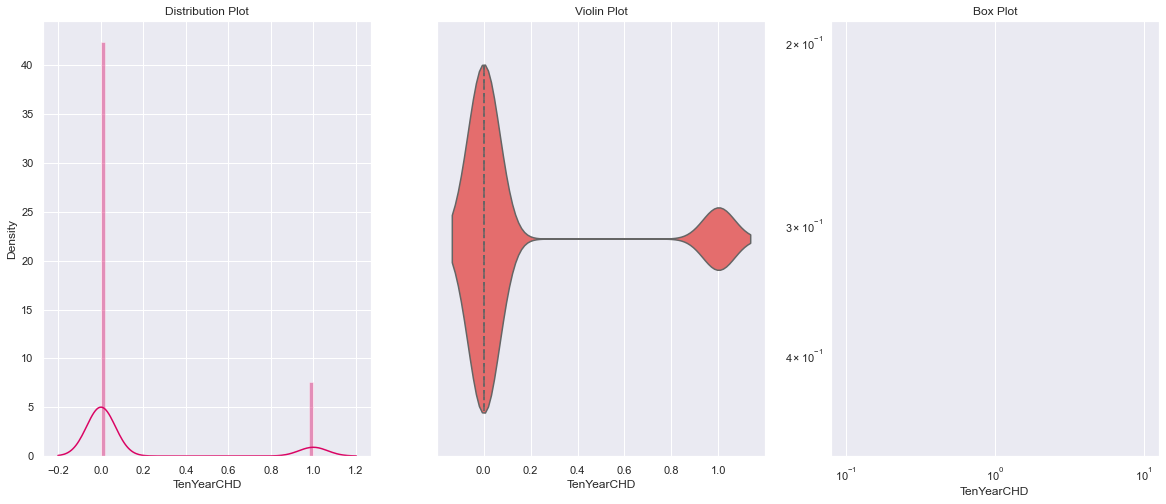

In [15]:
def uni(df,col,v,hue =None):

    sns.set(style="darkgrid")
    
    if v == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df1[col],ax=ax[0], color="#da0463")
        plt.yscale('log')
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df1, x=col,ax=ax[1], inner="quartile", color="#f85959")
        plt.yscale('log')
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df1, x=col,ax=ax[2],orient='v', color="#d89cf6")
        plt.xscale('log')
        plt.yscale('log')
plt.show()

for column in df1.columns:
    if df1[column].dtype != 'object':
        
        uni(df1,column,0)

In [ ]:
print(color.BOLD+color.PURPLE+'Ouliers in dataset:')

In [ ]:
list_of_numerics=df1.select_dtypes(include=['float','int32']).columns
types= df1.dtypes
overview= df1.apply(lambda x: [round(x.min()), 
                                 round(x.max()), 
                                 round(x.mean()), 
                                 round(x.quantile(0.5))] if x.name in list_of_numerics else x.unique())

outliers= df1.apply(lambda x: sum(
                                 (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                 (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))


explo = pd.DataFrame({'Types': types,
                      'Outliers': outliers})
explo


<h1> Outliers are present in data set , so we are treating these outliers </h1>

In [16]:
def cap_data(df):
    for col in df.columns:
        
        
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int32')):
    
            Q1=df[col].quantile(0.25)
            Q3=df[col].quantile(0.75)
            IQR=Q3-Q1
            lr = Q1-1.5*IQR
            ur = Q3+1.5*IQR
            df[col]=np.where(df[col]>ur,ur,df[col])
            df[col]=np.where(df[col]<lr,lr,df[col])

        else:
            df[col]=df[col]
    return df

final_df=cap_data(df1)
print(color.BOLD+color.PURPLE+'Function implemented to treat outliers.')


Function implemented to treat outliers.


In [17]:
list_of_numerics=df1.select_dtypes(include=['float','int32']).columns
types= df1.dtypes
overview= df1.apply(lambda x: [round(x.min()), 
                                 round(x.max()), 
                                 round(x.mean()), 
                                 round(x.quantile(0.5))] if x.name in list_of_numerics else x.unique())

outliers= df1.apply(lambda x: sum(
                                 (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                 (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))


explo = pd.DataFrame({'Types': types,
                      'Outliers': outliers})
explo


,Types,Outliers
male,int64,0
age,int64,0
education,float64,0
currentSmoker,int64,0
cigsPerDay,float64,0
BPMeds,float64,0
prevalentStroke,int64,0
prevalentHyp,int64,0
diabetes,int64,0
totChol,float64,0


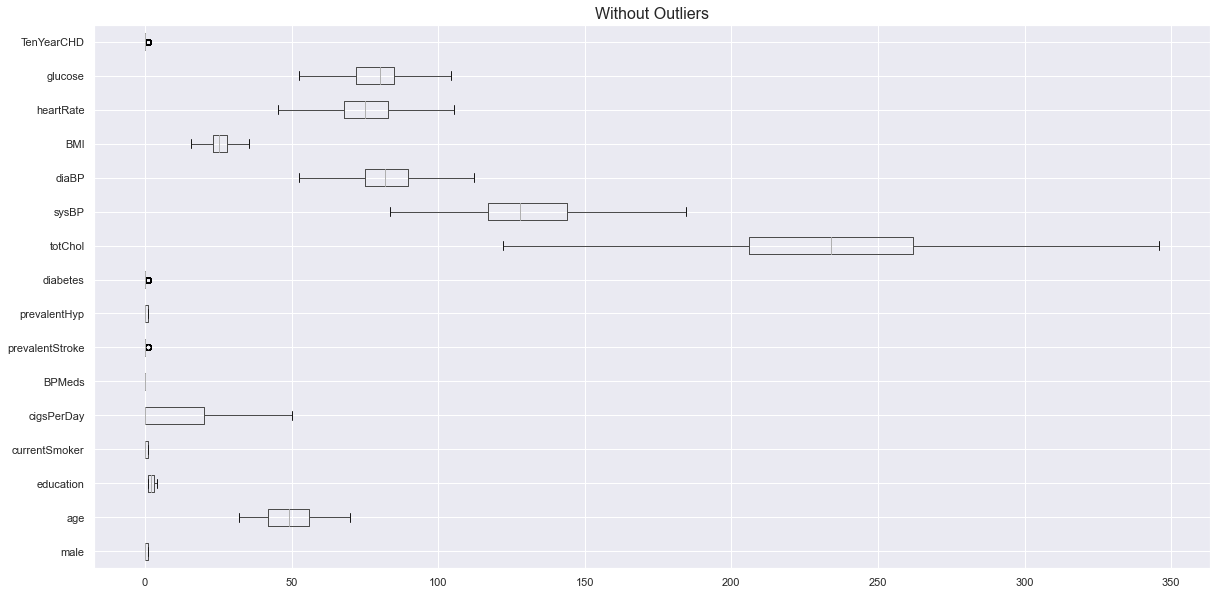

In [18]:
# construct box plot for continuous variables
cont=df1.dtypes[(df1.dtypes!='uint8') & (df1.dtypes!='bool')].index
plt.figure(figsize=(20,10))
df1[cont].boxplot(vert=False)
plt.title('Without Outliers',fontsize=16)
plt.show()

C:\Users\POOJA\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


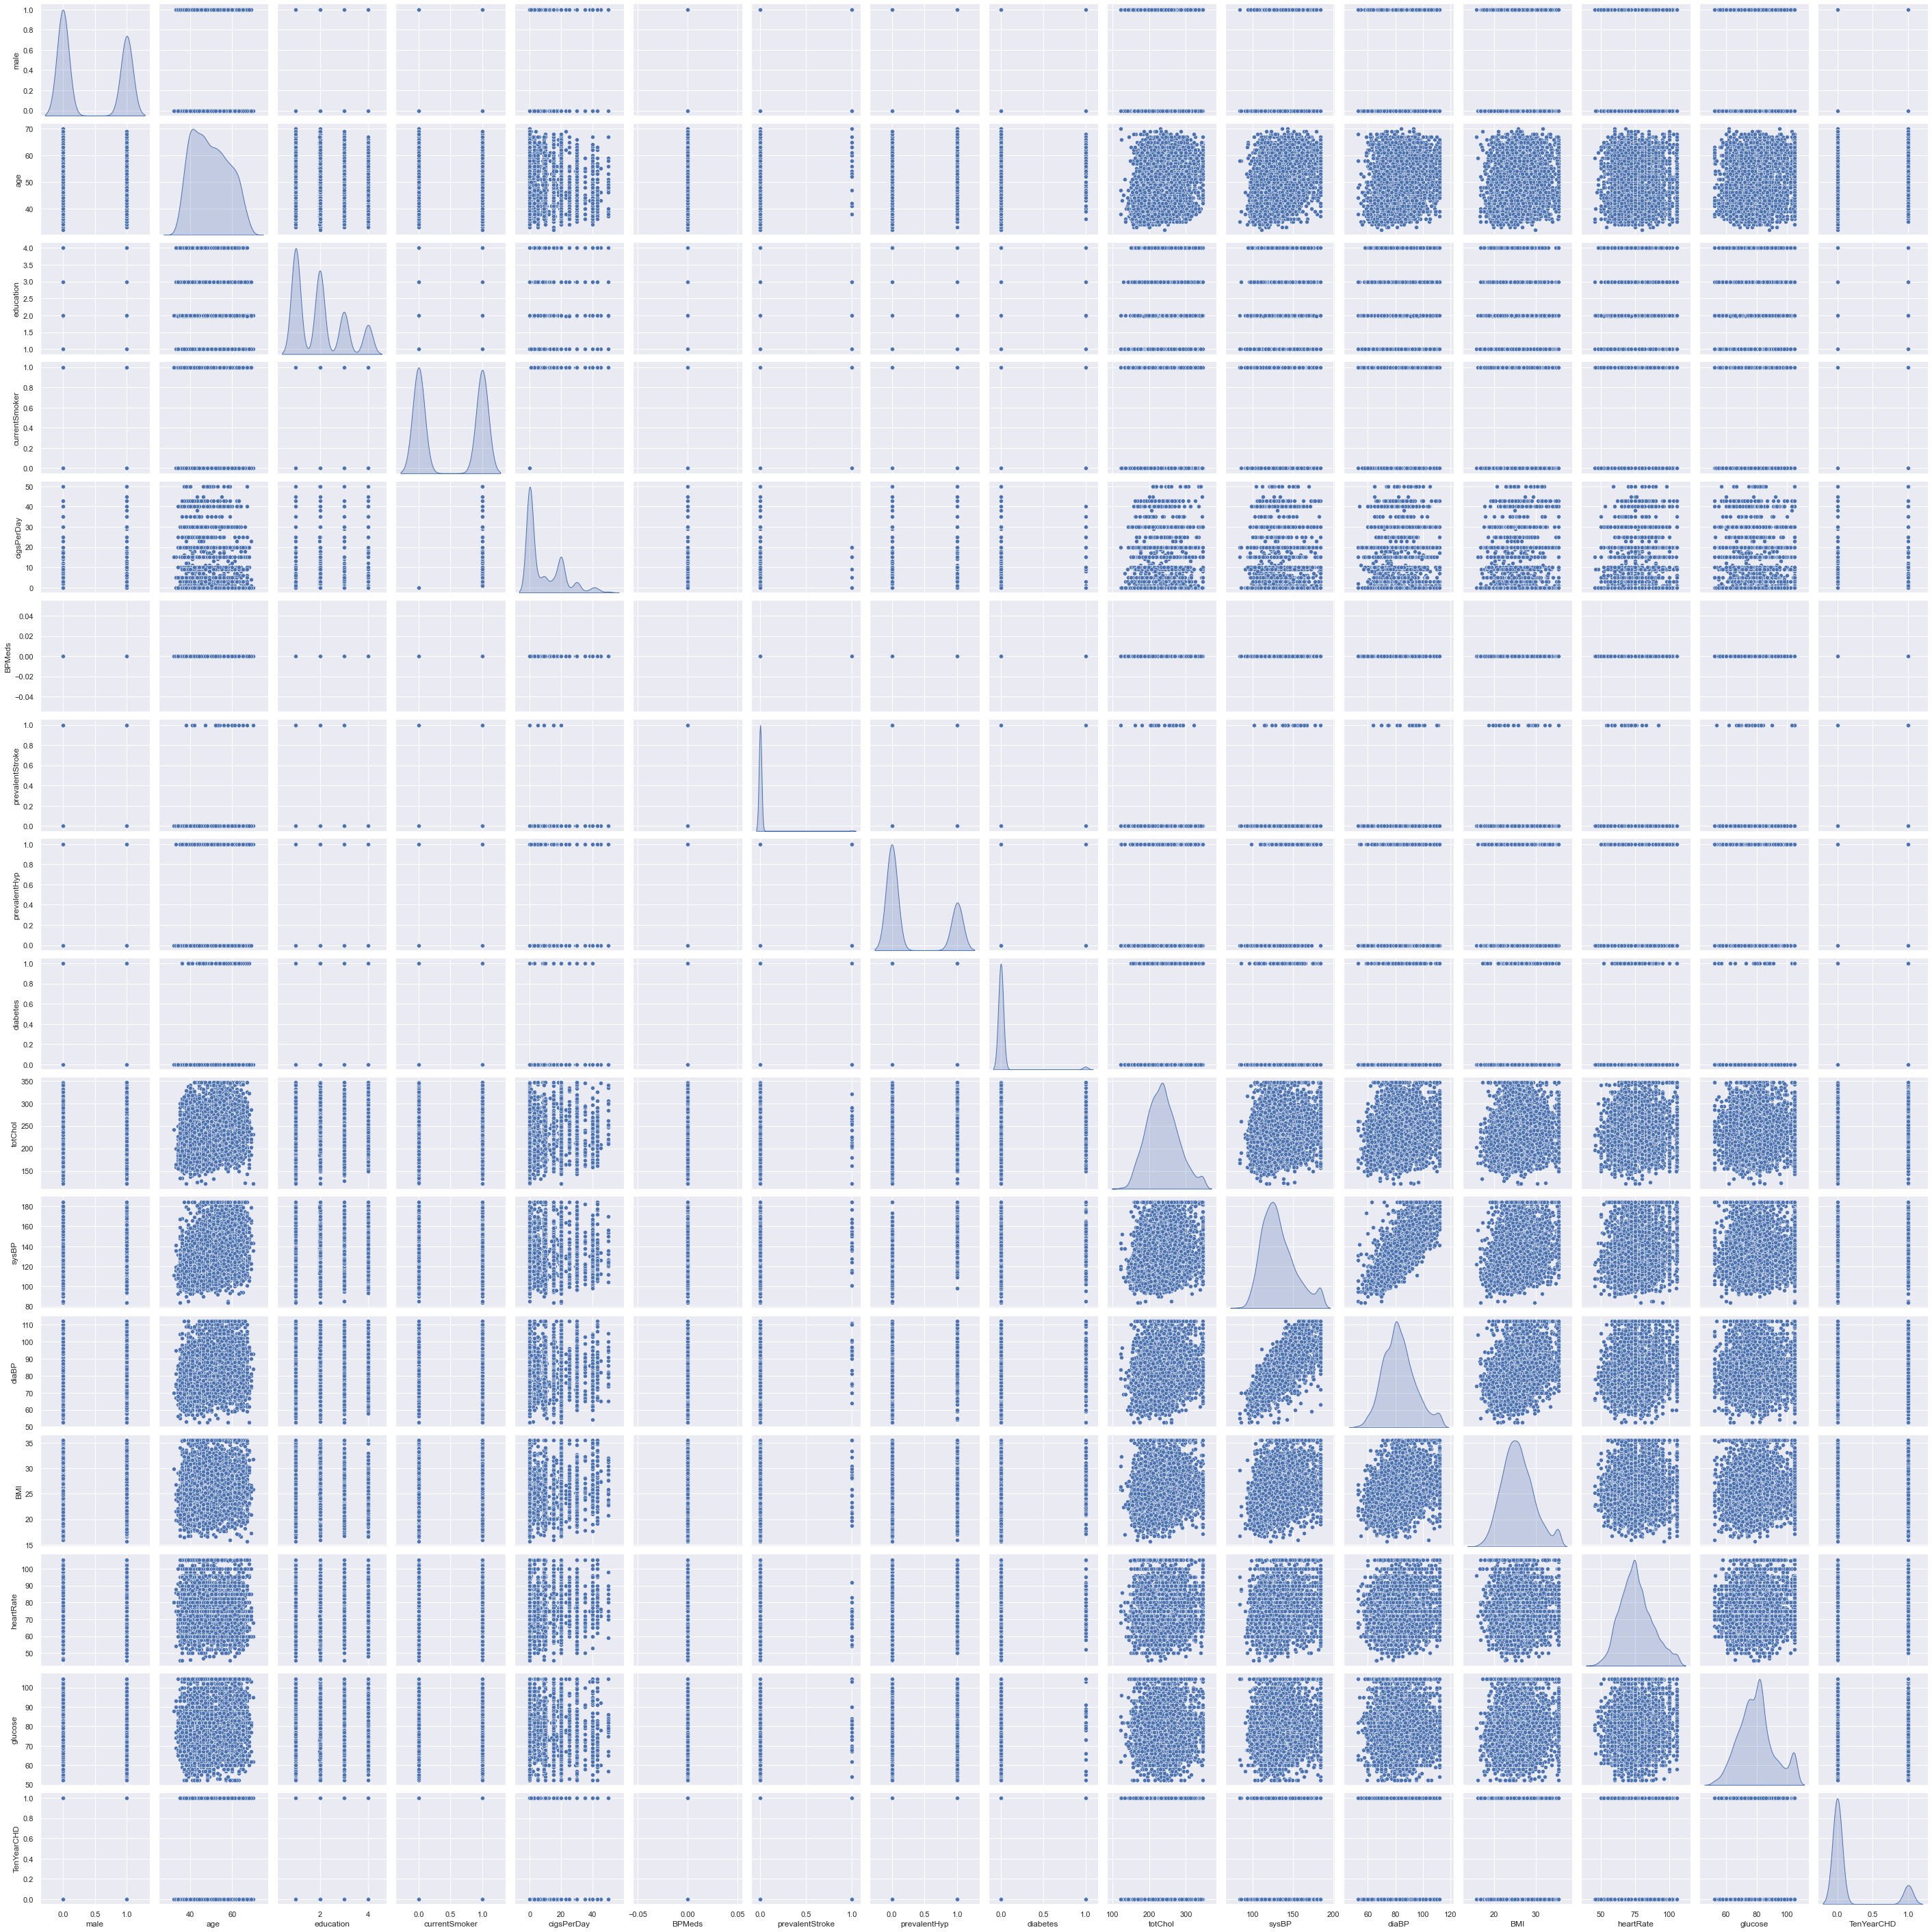

In [19]:
sns.pairplot(df1,diag_kind="kde")
plt.show()

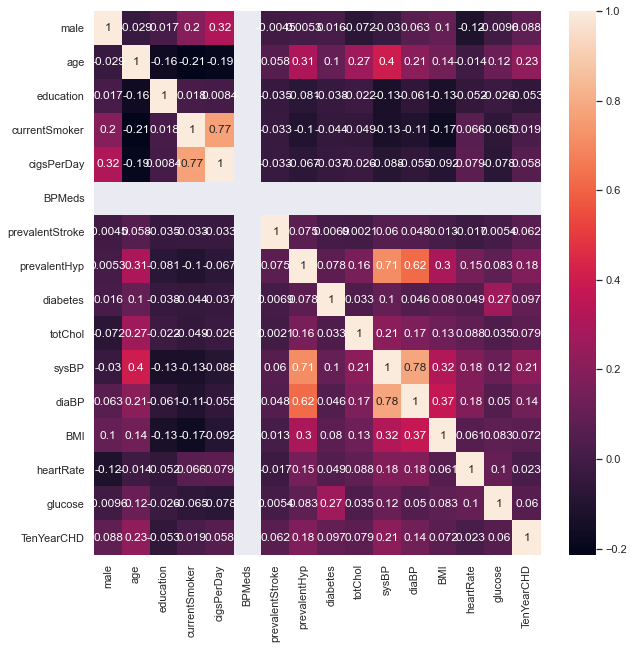

In [20]:
plt.figure(figsize = (10, 10))
sns.heatmap(df1.corr(), annot = True)
plt.show()


<h1> Step 6: Splitting the data set into Train and Test set</h1>

In [21]:
# Copy all the predictor variables into X dataframe
X = df1.drop('TenYearCHD', axis=1)

# Copy target into the y dataframe. 
y = df1['TenYearCHD']

In [22]:
print(color.BOLD+color.PURPLE+"Splitting Target(X) and Predictor(y) into training and test set in 70:30 ratio :")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)

Splitting Target(X) and Predictor(y) into training and test set in 70:30 ratio :


In [23]:
print(color.BOLD+color.PURPLE+'Data is split as independent and dependent variables into training and test set in 70:30 ratio:')
print("\n")
print(color.BOLD+color.PURPLE+'Number of rows and columns of the training set for the independent variables:',X_train.shape)
print(color.BOLD+color.PURPLE+'Number of rows and columns of the training set for the dependent variable:',y_train.shape)
print(color.BOLD+color.PURPLE+'Number of rows and columns of the test set for the independent variables:',X_test.shape)
print(color.BOLD+color.PURPLE+'Number of rows and columns of the test set for the dependent variable:',y_test.shape)

Data is split as independent and dependent variables into training and test set in 70:30 ratio:


Number of rows and columns of the training set for the independent variables: (2966, 15)
Number of rows and columns of the training set for the dependent variable: (2966,)
Number of rows and columns of the test set for the independent variables: (1272, 15)
Number of rows and columns of the test set for the dependent variable: (1272,)


<h1> Step 7: Scaling values in the dataset, so that all values are in the same scale </h1>

In [24]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [25]:
print(color.BOLD+color.PURPLE+'Scaled Train Data Set:')
X_train_norm[0]

Scaled Train Data Set:


array([1.        , 0.56756757, 0.        , 1.        , 0.06      ,
       0.        , 0.        , 0.        , 0.        , 0.22767857,
       0.37128713, 0.44222689, 0.53284165, 0.49166667, 0.29807692])

In [26]:
print(color.BOLD+color.PURPLE+'Scaled Test Data Set:')
X_test_norm[0]

Scaled Test Data Set:


array([1.        , 0.54054054, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.4375    ,
       0.43069307, 0.39180672, 0.43501009, 0.49166667, 0.41346154])

<h1> Step 7: Model Building </h1>

<h3>
Models in Keras are defined as a sequence of layers.
5 Sequential model are created and added one at a time 
 <br>
<br>Fully connected layers are defined using the Dense class.Activation functions used are relu, sigmoid.
    <br>
<br>The model expects rows of data with 15 variables so input_dim=15 </br>
</h3>

The first hidden layer has 12 nodes and uses the relu activation function.<br>
The second hidden layer has 8 nodes and uses the relu activation function.<br>
The third and fourth hidden layer have kernel_initializer=normal.<br>
The output layer has one node and uses the sigmoid activation function.<br>

In [27]:
# define the keras model
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(12, input_dim=15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(units = 160 , kernel_initializer = 'normal'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))



<h1> Step 8: Compiling the model using TensorFlow </h1>

In [28]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


<h1> Step 9 : Executing  model on  data || Fitting on trainging data and evaluating model accuracy on testing data set </h1>

In [33]:
# fit the keras model on the dataset
model.fit(X_train, y_train)

93/93 [==============================] - 0s 1ms/step - loss: 0.6505 - accuracy: 0.8388


In [34]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

93/93 [==============================] - 0s 1ms/step - loss: 0.6373 - accuracy: 0.8388
Accuracy: 83.88


In [35]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

40/40 [==============================] - 0s 921us/step - loss: 0.6319 - accuracy: 0.8695
Accuracy: 86.95
